# 弾道計算を最適化問題に落とし込んで解いてみるお試しプロジェクト

- 目的
    - モデル化とパラメータ最適化でどんな問題でも解くことができることを実証する
- 目標
    - 弾道計算で、弾丸の初速度と発射角度をパラメータとして、標的に命中させるための最適解を求める
- 手段
    - 弾道計算を最初はシンプルな問題から始めてだんだん要素を追加して難易度を上げることで解析的には解けない問題でも最適化問題に落とし込んで解けることを示す
    - 最適化には確率的な要素も含めたいのでmcmcを使う


# 発射機側のプラントモデルを作成
- 単純な運動方程式モデルで実装
- 時間シミュレーションを漸化式に基づいて実行する

In [39]:
# ボールを投げたときの初速度と角度をパラメータとして、ボールの軌道計算を関数の形に書き直したコード

# 必要なモジュールをインポート
import math
import matplotlib.pyplot as plt

In [40]:
# ボールの軌道を計算する関数を定義
def ball_trajectory(v0, theta, g):
    # 角度をラジアンに変換
    theta = math.radians(theta)

    # 水平方向と垂直方向の初速度を計算
    vx = v0 * math.cos(theta) # 水平方向の初速度 (m/s)
    vy = v0 * math.sin(theta) # 垂直方向の初速度 (m/s)

    # ボールが地面に着くまでの時間を計算
    t_max = 2 * vy / g # ボールが地面に着くまでの時間 (s)

    # 時間のリストを作成
    t_list = [t / 100 for t in range(int(t_max * 100) + 1)] # 時間のリスト (s)

    # 水平方向と垂直方向の位置を計算
    x_list = [vx * t for t in t_list] # 水平方向の位置のリスト (m)
    y_list = [vy * t - 0.5 * g * t**2 for t in t_list] # 垂直方向の位置のリスト (m)

    # 位置と時間のリストを返す
    return x_list, y_list, t_list

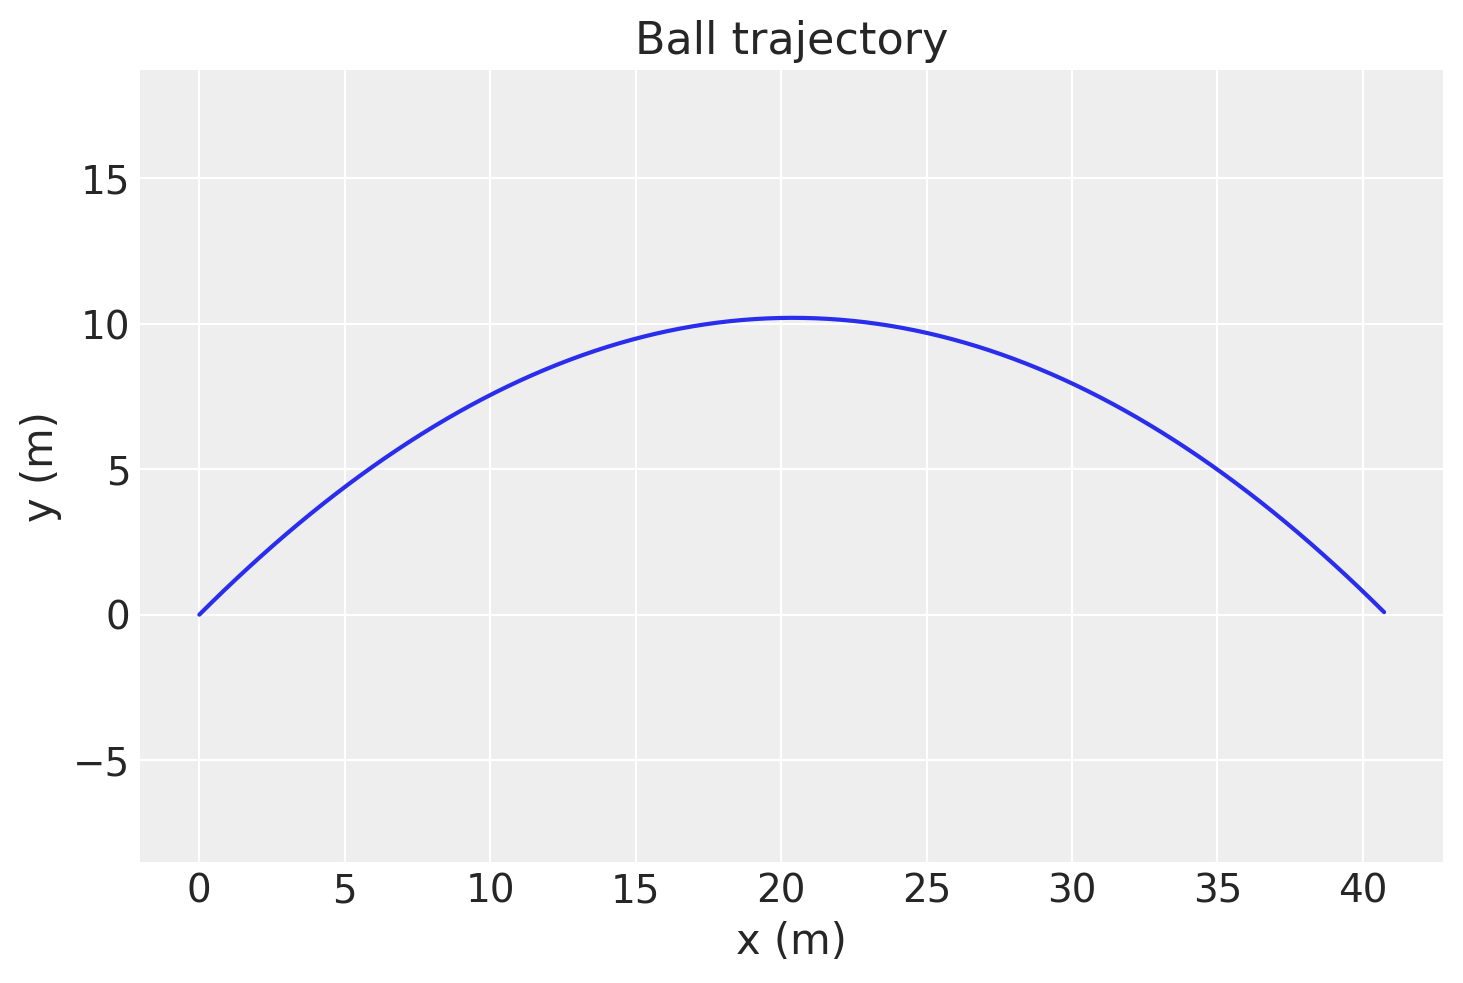

In [41]:
# パラメータの設定
v0 = 20 # 初速度 (m/s)
theta = 45 # 投げる角度 (度)
g = 9.8 # 重力加速度 (m/s^2)

# ボールの軌道を計算する関数を呼び出す
x_list, y_list, t_list = ball_trajectory(v0, theta, g)

# ボールの軌道をプロット
plt.plot(x_list, y_list) # ボールの軌道をプロット
plt.xlabel("x (m)") # x軸のラベル
plt.ylabel("y (m)") # y軸のラベル
plt.title("Ball trajectory") # タイトル
plt.axis('equal') # 縦横比を等しくする
plt.show() # グラフを表示

## MCMCモデルとして実装
- 初速度と発射角度にばらつきがあるモデルとして実装してみる
- 観測にはばらつきはないものとする
- ターゲットの位置±1mまでなら命中と判定する
- 命中率99.99%以上とするために必要な発射角度、初速度とそれらのばらつき範囲を最適化問題にして求めてみる

In [42]:
import arviz as az
import numpy as np
import pymc as pm

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Running on PyMC v5.9.0


In [43]:
# ボールの軌道計算をする関数を定義（pymcで使えるように修正）
def ball_trajectory_pm(v0, theta, g):
    # 角度をラジアンに変換
    theta = theta * 2 * math.pi / 360

    # 水平方向と垂直方向の初速度を計算
    vx = v0 * pm.math.cos(theta) # 水平方向の初速度 (m/s)
    vy = v0 * pm.math.sin(theta) # 垂直方向の初速度 (m/s)

    # ボールが地面に着くまでの時間を計算
    t_max = 2 * vy / g # ボールが地面に着くまでの時間 (s)

    # 着地点の水平距離を計算
    x_end = vx * t_max

    # ボールの着地位置を返す
    return x_end

In [61]:
x_obs = np.ones(1000) * 30

In [48]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    v0 = Normal("v0", 20, sigma=5)  # [m/s]
    theta = Normal("theta", 45, sigma=3.0)  # [degree]

    x_true = ball_trajectory_pm(v0, theta, 9.8)

    # Define likelihood
    likelihood = Normal("y", mu=x_true, sigma=0.01, observed=x_obs)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v0, theta]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v0'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

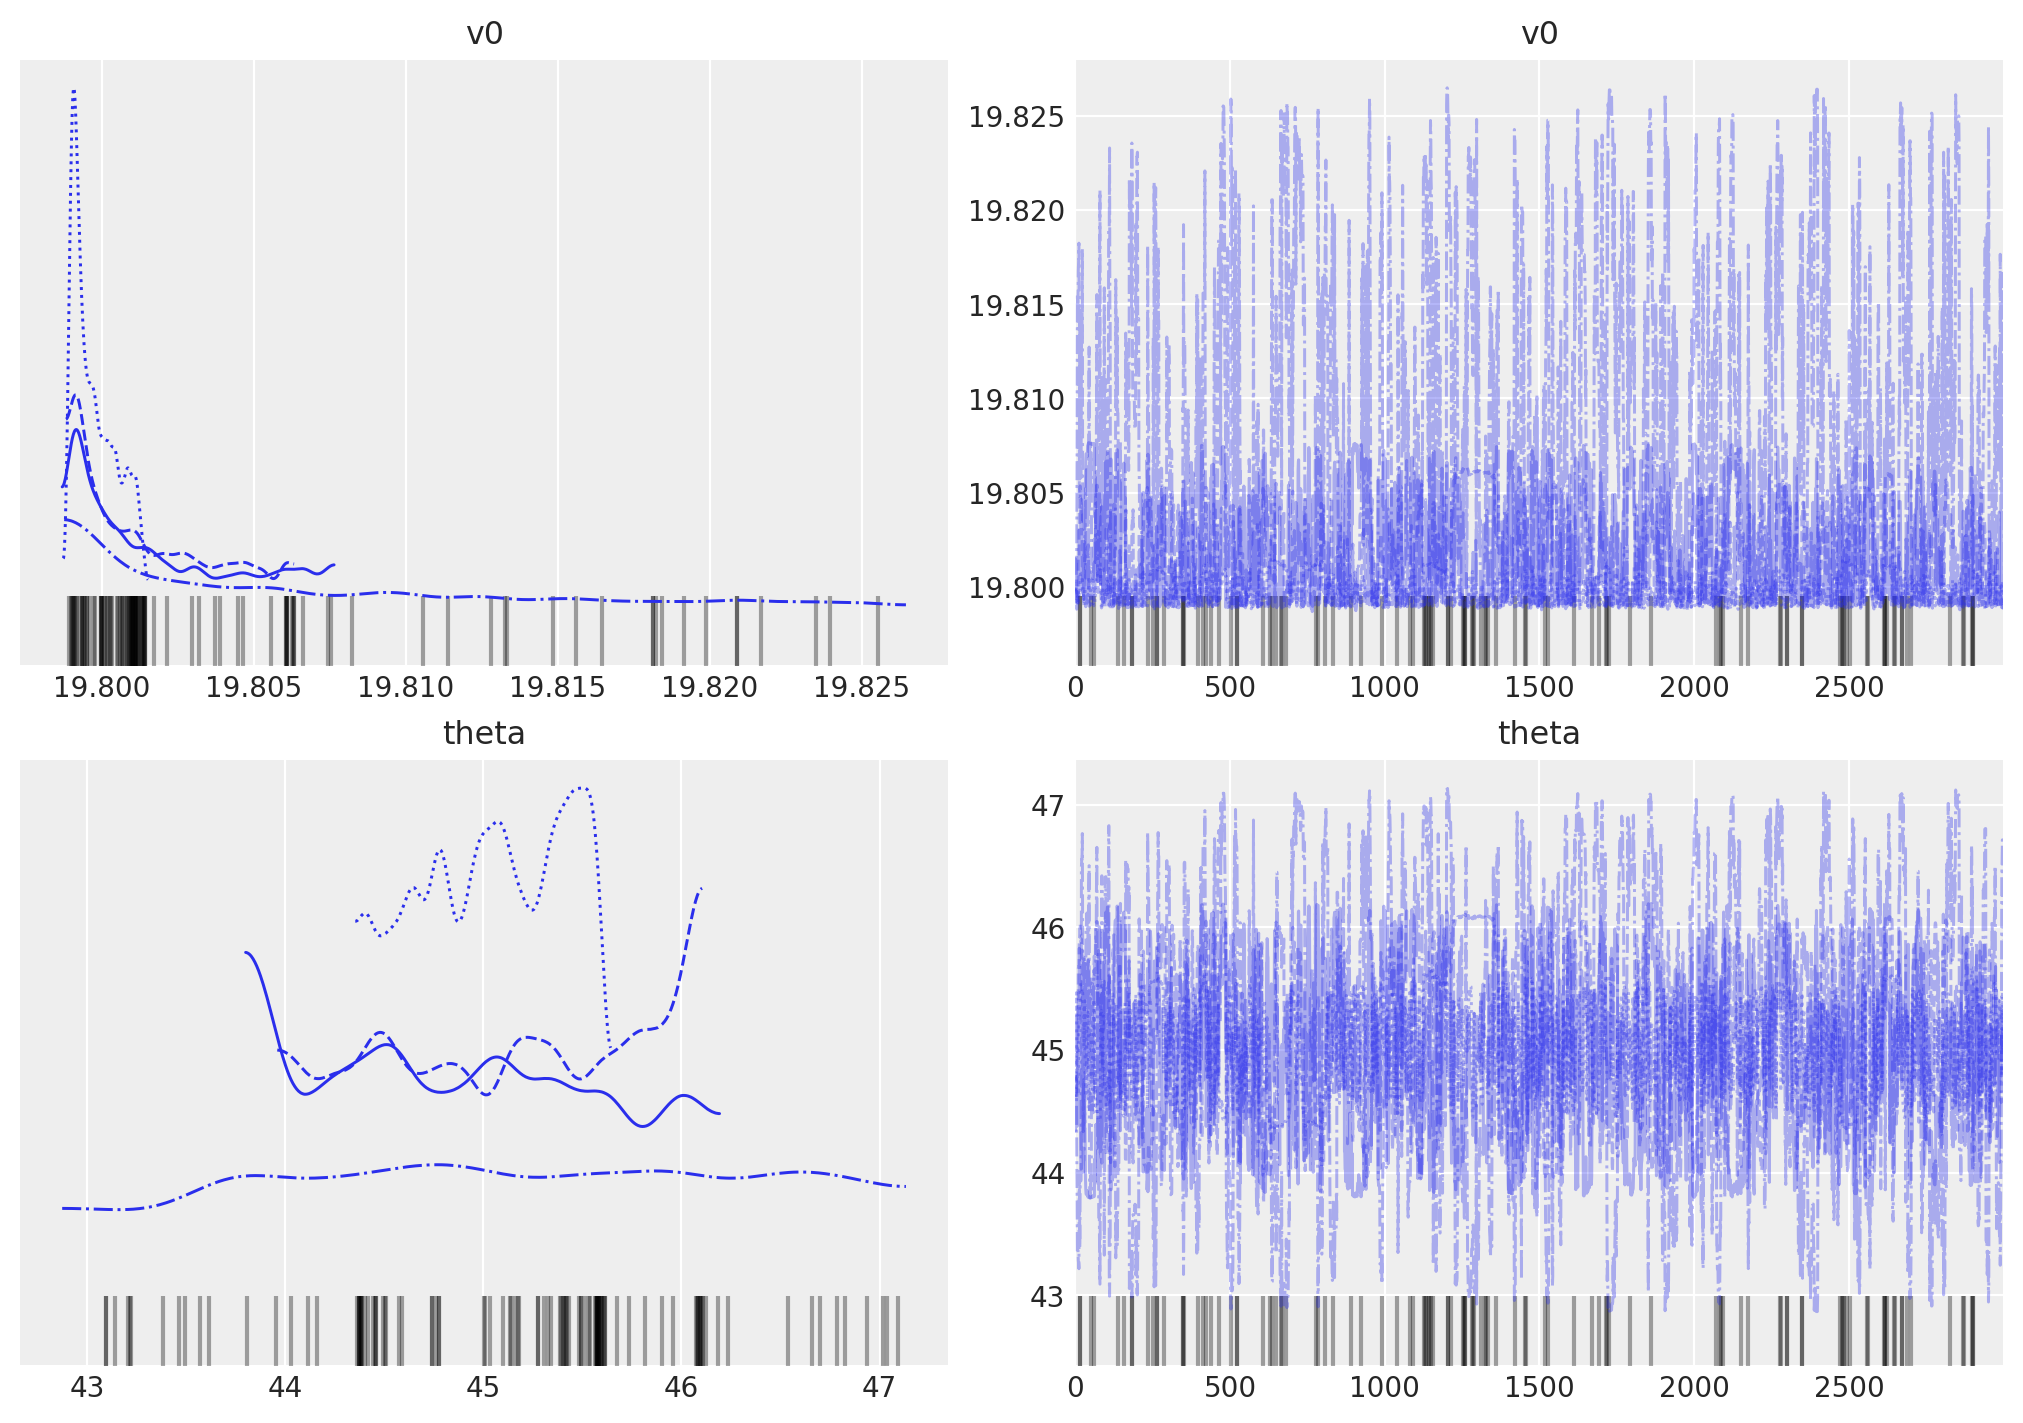

In [49]:
az.plot_trace(idata, figsize=(10, 7))

収束してないが、まあこれは想定内の結果。だって目標地点に落下するための初速度と角度の組み合わせはひととおりに決まらないので。今回のお試しモデルではうまくいかないってことだ。

In [83]:
with Model() as model2:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    v0 = 20  # [m/s]
    theta = Normal("theta", 90, sigma=30.0)  # [degree]

    x_true = ball_trajectory_pm(v0, theta, 9.8)

    # Define likelihood
    likelihood = Normal("y", mu=x_true, sigma=0.01, observed=x_obs)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

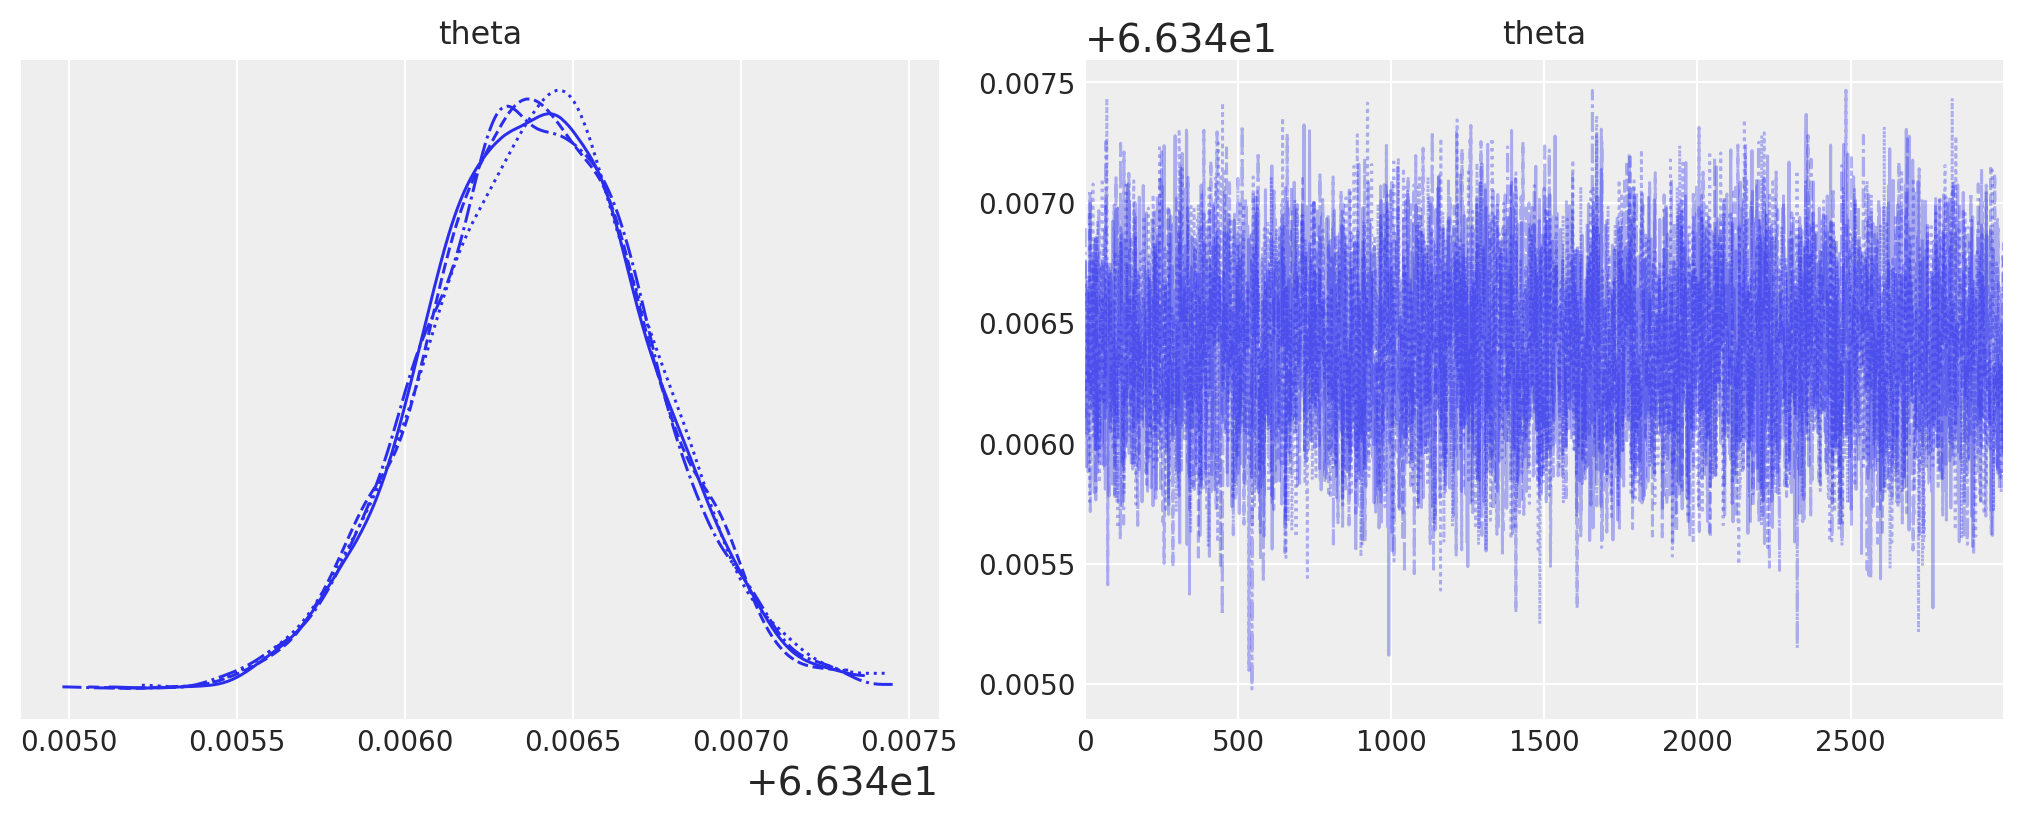

In [84]:
az.plot_trace(idata, figsize=(10, 4))

Sampling: [y]


/home/atsushi/dev/trajectory_calculation/venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


<Axes: xlabel='y / y'>

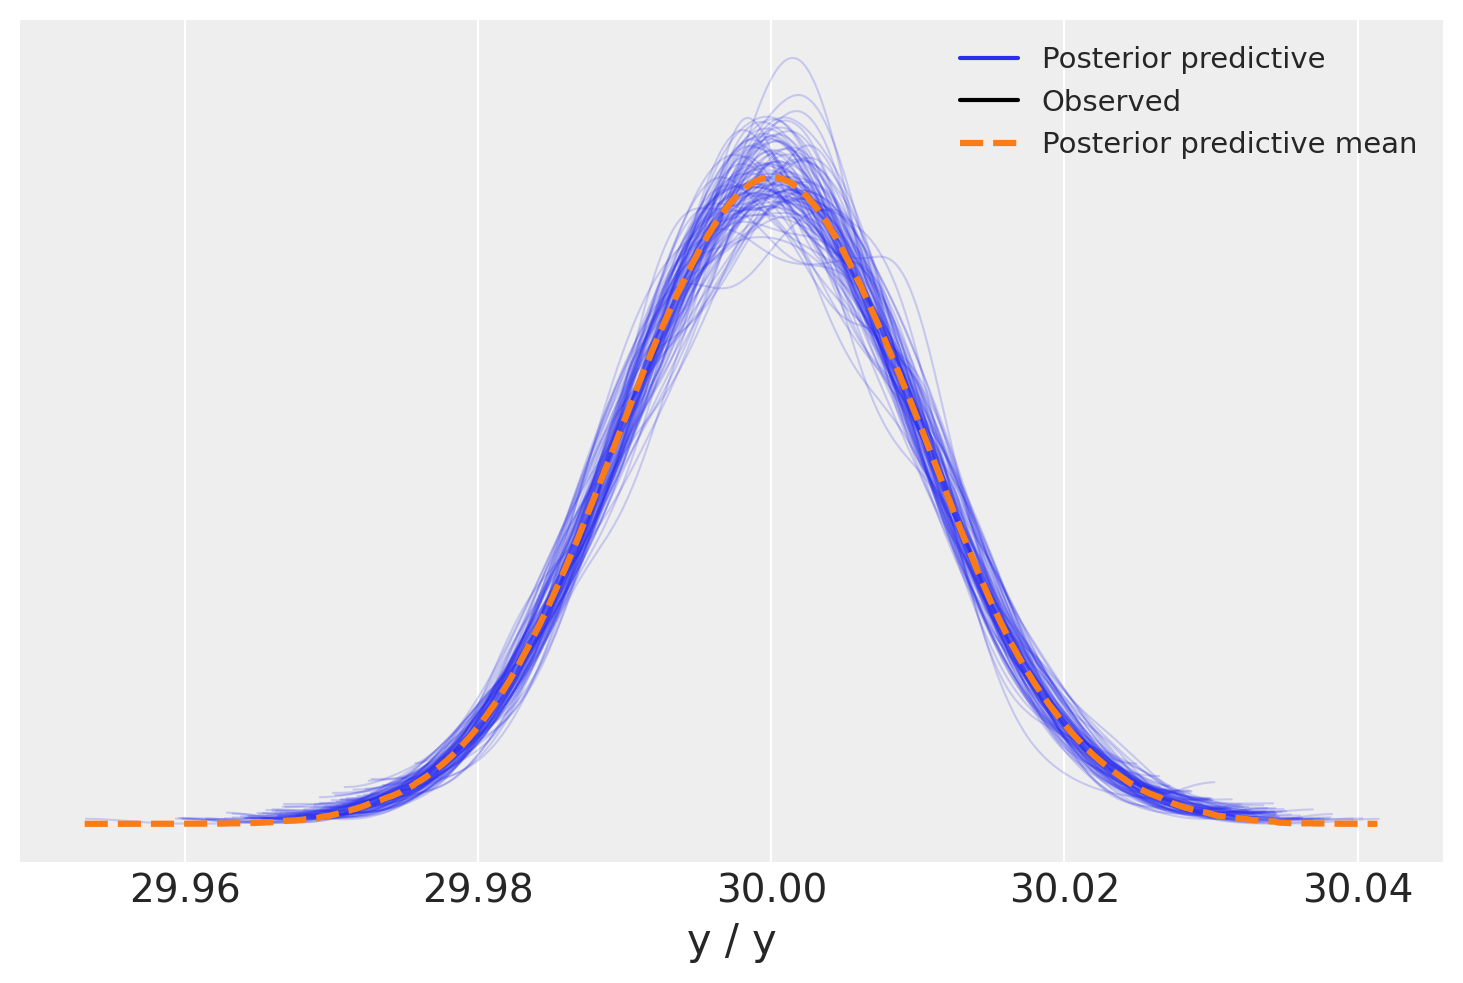

In [85]:
# 事後予測分布からサンプルを抽出する
ppc = pm.sample_posterior_predictive(idata, model=model2)
az.plot_ppc(ppc, num_pp_samples=100)

In [86]:
theta_post = pm.summary(idata, var_names=['theta'])['mean'].values
theta_post

array([66.346])

初速度を固定値にしてみたらちゃんと収束した。ただし、解は2つあるはずだけど、初期値と近い方だけが計算結果として得られた。これはベイズ推論を使いこなすうえで重要な知見かもしれない。初期値が大事。